In [1]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6
from sklearn.feature_extraction.text import CountVectorizer
import re

In [2]:
from nltk.classify import NaiveBayesClassifier
from nltk.corpus import subjectivity
from nltk.sentiment import SentimentAnalyzer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import pandas as pd

In [3]:
from sklearn.linear_model import LinearRegression,LogisticRegression
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

In [4]:
from sklearn.metrics import classification_report

In [5]:
# BA boing, KO coca-cola

## Стратегия

In [691]:
GROW_UP=0
GROW_DOWN=1
class Strategy:
    def __init__(self,prices_open,prices_close,predictions,true_predictions,shift):
        self.prices_open=prices_open
        self.shift=shift
        self.prices_close=prices_close
        self.predictions=predictions
        self.true_predictions=true_predictions
        self.profits=np.zeros((2,self.prices_open.shape[0]))
        self.alternative_profits=np.zeros((2,self.prices_open.shape[0]))
        self.profits_noactions=np.zeros(self.prices_open.shape[0])
        self.true_profits=np.zeros((2,self.prices_open.shape[0]))
        
    def info(self):
        print('Methods: calculate_true_profits(),calculate_profits(strategy_name)')
    
    def calculate_true_profits(self):
        for i in range(self.predictions[0,:].shape[0]):
            if self.true_predictions[GROW_DOWN][i]==1.0:  
                if i+self.shift<self.predictions[0,:].shape[0]:
                    self.true_profits[GROW_DOWN][i]=self.prices_open[i]-np.min(self.prices_close[i:i+self.shift])
                    
                else:
                     self.true_profits[GROW_DOWN][i]=self.prices_open[i]-np.min(self.prices_close[i:])
            else:
                self.true_profits[GROW_DOWN][i]=0
    def strategy1(self):
        #to sell or by with open tomorrow
        for i in range(self.predictions[0,:].shape[0]):
            if self.predictions[GROW_DOWN][i]==1.0:
                if i+self.shift<self.predictions[0,:].shape[0]:
                    self.profits[GROW_DOWN][i]=self.prices_open[i]-np.min(self.prices_close[i:i+self.shift])
                    self.alternative_profits[GROW_DOWN][i]=self.prices_open[i]-np.max(self.prices_close[i:i+self.shift])
                else:
                    self.profits[GROW_DOWN][i]=self.prices_open[i]-np.min(self.prices_close[i:])
                    self.alternative_profits[GROW_DOWN][i]=self.prices_open[i]-np.max(self.prices_close[i:])
            else:
                self.profits[i]=0
                self.alternative_profits[i]=0
            if self.predictions[GROW_UP][i]==1.0:
                    if i+self.shift<self.predictions[0,:].shape[0]:
                        self.profits[GROW_UP][i]=-1*self.prices_open[i]+np.max(self.prices_close[i:i+self.shift])
                        self.alternative_profits[GROW_UP][i]=-1*self.prices_open[i]+np.min(self.prices_close[i:i+self.shift])
                    else:
                        self.profits[GROW_UP][i]=-1*self.prices_open[i]+np.max(self.prices_close[i:])
                        self.alternative_profits[GROW_UP][i]=-1*self.prices_open[i]+np.min(self.prices_close[i:])   
            else:
                 self.true_profits[GROW_UP][i]=0   
        
    def calculate_profits(self,strategy):
        if strategy=='grow_down1':
            self.strategy1()
            
            
def use_strategy(y_test,y_predicted,y_predicted_news,shift,prices_open,prices_close):
    predictions=np.zeros((2,y_predicted.shape[0]))
    predictions[GROW_DOWN,:]=y_predicted
    true_predictions=np.zeros((2,y_predicted.shape[0]))
    true_predictions[GROW_DOWN,:]=y_test
    strategy=Strategy(prices_open[1:],prices_close[1:],predictions,true_predictions,shift)
    strategy.calculate_true_profits()
    strategy. calculate_profits('grow_down1')
    
    
    predictions_news=np.zeros((2,y_predicted_news.shape[0]))
    predictions_news[GROW_DOWN,:]=y_predicted_news
    true_predictions=np.zeros((2,y_predicted_news.shape[0]))
    #true_predictions[GROW_DOWN,:]=y_test
    strategy_news=Strategy(prices_open[1:],prices_close[1:],predictions_news,true_predictions,shift)
    strategy_news.calculate_true_profits()
    strategy_news.calculate_profits('grow_down1')
    return strategy, strategy_news

def print_info(days,strategy,strategy_news):
    print (days,"Дней")
    print('Для падения цены')
    print('Без новостей:')
    print(' Model profit= ',np.sum(strategy.profits[GROW_DOWN][:days]))
    print(' Alternative profit= ',np.sum(strategy.alternative_profits[GROW_DOWN][:days]))
    print(' True profit= ',np.sum(strategy.true_profits[GROW_DOWN][:days]))
    print('С новостями:')
    print(' Model profit= ',np.sum(strategy_news.profits[GROW_DOWN][:days]))
    print(' Alternative profit= ',np.sum(strategy_news.alternative_profits[GROW_DOWN][:days]))
    print(' True profit= ',np.sum(strategy_news.true_profits[GROW_DOWN][:days]))
    print('Для роста цены')
    print('Без новостей:')
    print(' Model profit= ',np.sum(strategy.profits[GROW_UP][:days]))
    print(' Alternative profit= ',np.sum(strategy.alternative_profits[GROW_UP][:days]))
    print(' True profit= ',np.sum(strategy.true_profits[GROW_UP][:days]))
    print('С новостями:')
    print(' Model profit= ',np.sum(strategy_news.profits[GROW_UP][:days]))
    print(' Alternative profit= ',np.sum(strategy_news.alternative_profits[GROW_UP][:days]))
    print(' True profit= ',np.sum(strategy_news.true_profits[GROW_UP][:days]))
    
    
def plot_info(strategy_news,strategy):
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20, 7))
    ax[0].set_title('График выгоды падения цены')
    ax[0].plot(strategy_news.profits[GROW_DOWN][:],c='b',label='с новостями')
    ax[0].plot(strategy.profits[GROW_DOWN][:],c='orange',label='без новостей')
    ax[0].legend()
    
    ax[1].set_title('График выгоды роста цены')
    ax[1].plot(strategy_news.profits[GROW_UP][:],c='b',label='с новостями')
    ax[1].plot(strategy.profits[GROW_UP][:],c='orange',label='без новостей')
    ax[1].legend()
    

In [403]:
arr=np.array([1,2,3,4])
arr[0:2]

array([1, 2])

## Создание таргета

In [188]:
def create_target(df,shift,interval):
    array_close=df['close'].values
    array_open=df['open'].values
    deltas=np.zeros(len(array_open))
    grow_up=np.zeros(len(array_open))
    for i in range(len(array_open)):
        if i+shift>df.shape[0]:
            shift=shift-1
        delta=(np.max(array_close[i:i+shift])-array_open[i])/array_open[i]
        deltas[i]=delta
        if (delta>=interval):
            grow_up[i]=1
    df['grow_up']=grow_up
    df['grow_up_value']=deltas
    
def create_target_down(df,shift,interval):
    array_close=df['close'].values
    array_open=df['open'].values
    deltas=np.zeros(len(array_open))
    grow_down=np.zeros(len(array_open))
    for i in range(len(array_open)):
        if i+shift>df.shape[0]:
            shift=shift-1
        delta=(-1*np.min(array_close[i:i+shift])+array_open[i])/array_open[i]
        deltas[i]=delta
        if (deltainterval):
            grow_down[i]=1
    df['grow_down']=grow_down
    df['grow_down_value']=deltas
            

In [137]:
arr=np.array([1,2,3,4])
arr[1:1+2]

array([2, 3])

### *Создание датасета с метриками на основе новостей*

In [7]:
# убрать дублирующиеся новости
def create_data_frame(json_news):
    ids=[]
    titles=[]
    summaries=[]
    dates=[]
    times=[]
    for i in range(len(json_news)):
        summary=re.sub('[^a-z,\']',  ' ' , json_news[i]['summary'].lower())
        if (i>0): 
            ind=len(summaries)-1
            if (not(summary.find(summaries[ind-1])>=0 or summaries[ind-1].find(summary)>=0)):
                ids.append(json_news[i]['id'])
                titles.append(re.sub('[^a-z,\']',  ' ' , json_news[i]['title'].lower()))
                summaries.append(summary)
                tmp=json_news[i]['publication_date']
                tmp=tmp.replace('Z','')
                res=tmp.split("T")
                dates.append(res[0])
                times.append(res[1])
        else:
            print('jjj')
            ids.append(json_news[i]['id'])
            titles.append(re.sub('[^a-z,\']',  ' ' , json_news[i]['title'].lower()))
            summaries.append(summary)
            tmp=json_news[i]['publication_date']
            tmp=tmp.replace('Z','')
            res=tmp.split("T")
            dates.append(res[0])
            times.append(res[1])
            #print(len(summaries))
            
    df=pd.DataFrame()
    df['id']=ids
    df['date']=dates
    df['time']=times
    df['title']=titles
    df['summary']=summaries
    return df
    
def clean_data(data):
    for i in range(0,data.shape[0]):
        print("----",i,"------")
        try:
            data.text[i]=re.sub('[^а-я]', ' ',  data.text[i].lower())
            data.title[i]=re.sub('[^а-я]', ' ',  data.title[i].lower())
        except:
            pass
        
def calc_sentiment(sentence):
    sid = SentimentIntensityAnalyzer()
    ss = sid.polarity_scores(sentence)    
    return ss
def calc_sentiment_neg(sentence):
    sid = SentimentIntensityAnalyzer()
    ss = sid.polarity_scores(sentence)    
    return ss['neg']

def add_sentiment(df,column):
    res=df[column].apply(func=calc_sentiment)
    return res

In [123]:
res=add_sentiment(apple_df,'summary')


In [124]:
pos=[]
neg=[]
neu=[]
compound=[]
i=0
for sent in res:
    print(i)
    pos.append(sent['pos'])
    neg.append(sent['neg'])
    neu.append(sent['neu'])
    compound.append(sent['compound'])
    i+=1
    

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [125]:
apple_df['pos_summary']=pos
apple_df['neg_summary']=neg
apple_df['neu_summary']=neu
apple_df['compound_summary']=compound

In [5]:
import nltk
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/lena/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [7]:
from nltk.corpus import stopwords
print(stopwords.words('english'))

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [8]:
from nltk.corpus import stopwords
#print(stopwords.words('english'))

In [9]:
from nltk import word_tokenize

In [13]:
from string import punctuation
punctuation
noise = stopwords.words('russian') + list(punctuation)

In [15]:
vec = CountVectorizer(ngram_range=(1, 1), tokenizer=word_tokenize, stop_words=noise)
bow = vec.fit_transform(["This my way to live. I love you!"])

/home/lena/anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['``'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


In [2]:
import json

with open('AAPL.json') as f:
     apple_news = json.load(f)


In [84]:
apple_df=create_data_frame(apple_news)

jjj


In [63]:
print(apple_df.loc[0].summary)
print(apple_df.loc[1].summary)

thursday's bearish reversal for the nasdaq, apple and other top techs shows how risky the stock market is now  peloton jumped late on earnings 
thursday's bearish reversal for the nasdaq, apple and other top techs shows how risky the stock market is now  peloton jumped late on earnings 


In [127]:

#apple_df.to_csv('apple_v3.csv')

In [115]:
apple_df.loc[3].title

'     mln options unwind signals more caution on tech stocks'

In [ ]:
apple_df

(array([368., 249., 163., 264., 223., 126.,  52.,  20.,  15.,  11.,   4.,
          5.,   3.,   3.,   2.]),
 array([  1. ,  18.6,  36.2,  53.8,  71.4,  89. , 106.6, 124.2, 141.8,
        159.4, 177. , 194.6, 212.2, 229.8, 247.4, 265. ]),
 <BarContainer object of 15 artists>)

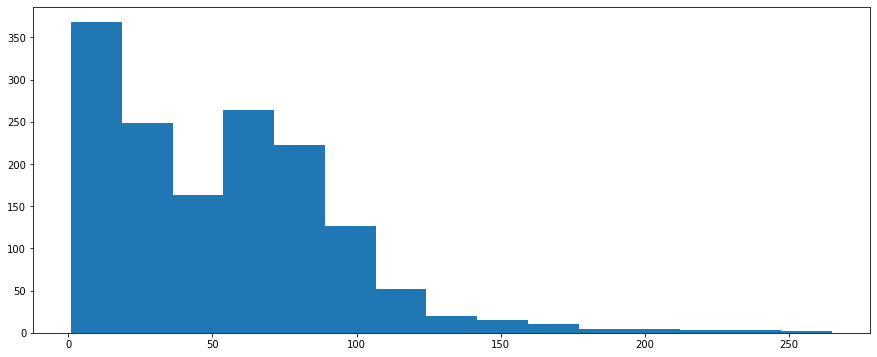

In [136]:
plt.hist(apple_df.groupby('date').compound_summary.count(),bins=15)

In [143]:
#plt.plot(apple_df.date.unique())

### Создание датасета с усредненными характеристиками новостей на каждый день

In [4]:
df_news=pd.read_csv('apple_v3.csv')

In [7]:
df_prices=pd.read_csv('AAPL .csv')

In [ ]:
df_prices.to_parquet('prices.parquet')

In [8]:
df_prices,df_news

,Date,Open,High,Low,Close,Adj Close,Volume
0,2015-10-05,27.469999,27.842501,27.267500,27.695000,25.593342,208258800
1,2015-10-06,27.657499,27.934999,27.442499,27.827499,25.715784,192787200


In [15]:
df_prices['Date'] = pd.to_datetime(df_prices.Date)
df_news['date'] = pd.to_datetime(df_news.date)
df_prices['jDate'] = df_prices.Date.dt.date
df_news['jDate'] = df_news.date.dt.date

In [27]:
pd.merge(df_news,df_prices,how='outer',on='jDate').to_parquet('joinedNewsAndPrices.parquet')

In [283]:
df=pd.read_parquet('joinedNewsAndPrices.parquet')

In [284]:
df.columns

Index(['Unnamed: 0', 'id', 'date', 'time', 'title', 'summary', 'pos_title',
       'neg_title', 'neu_title', 'compound_title', 'pos_summary',
       'neg_summary', 'neu_summary', 'compound_summary', 'jDate', 'Date',
       'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'],
      dtype='object')

In [285]:
df.shape

(80571, 22)

In [295]:
df.dropna(inplace=True)

In [296]:
news_metrics=pd.DataFrame()
news_metrics['Date']=df.date.unique()
news_metrics['news_count']=df.groupby('date').title.count().values
news_metrics['title_compound_mean']=df.groupby('date').compound_title.mean().values
news_metrics['title_compound_mediana']=df.groupby('date').compound_title.median().values
news_metrics['title_pos_mean']=df.groupby('date').pos_title.mean().values
news_metrics['title_pos_mediana']=df.groupby('date').pos_title.median().values
news_metrics['title_neu_mean']=df.groupby('date').neu_title.mean().values
news_metrics['title_neu_mediana']=df.groupby('date').neu_title.median().values
news_metrics['title_neg_mean']=df.groupby('date').neg_title.mean().values
news_metrics['title_neg_mediana']=df.groupby('date').neg_title.median().values


In [297]:
news_metrics['summary_compound_mean']=df.groupby('date').compound_summary.mean().values
news_metrics['summary_compound_mediana']=df.groupby('date').compound_summary.median().values
news_metrics['summary_pos_mean']=df.groupby('date').pos_summary.mean().values
news_metrics['summary_pos_mediana']=df.groupby('date').pos_summary.median().values
news_metrics['summary_neu_mean']=df.groupby('date').neu_summary.mean().values
news_metrics['summary_neu_mediana']=df.groupby('date').neu_summary.median().values
news_metrics['summary_neg_mean']=df.groupby('date').neg_summary.mean().values
news_metrics['summary_neg_mediana']=df.groupby('date').neg_summary.median().values

In [298]:
news_metrics['open']=df.groupby('date').Open.max().values
news_metrics['close']=df.groupby('date').Close.max().values
news_metrics['high']=df.groupby('date').High.max().values
news_metrics['low']=df.groupby('date').Low.max().values
news_metrics['volume']=df.groupby('date').Volume.max().values

In [299]:
news_metrics.head(2)

,Date,news_count,title_compound_mean,title_compound_mediana,title_pos_mean,title_pos_mediana,title_neu_mean,title_neu_mediana,title_neg_mean,title_neg_mediana,...,summary_pos_mediana,summary_neu_mean,summary_neu_mediana,summary_neg_mean,summary_neg_mediana,open,close,high,low,volume
0,2020-09-11,2,0.1679,0.1679,0.302,0.302,0.523,0.523,0.175,0.175,...,0.302,0.523,0.523,0.175,0.175,24.3050,24.475000,24.522499,24.209999,140560800.0
1,2020-09-10,1,0.0000,0.0000,0.000,0.000,1.000,1.000,0.000,0.000,...,0.000,1.000,1.000,0.000,0.000,24.6675,24.905001,24.934999,24.527500,152675200.0


In [300]:
news_metrics.shape

(1049, 23)

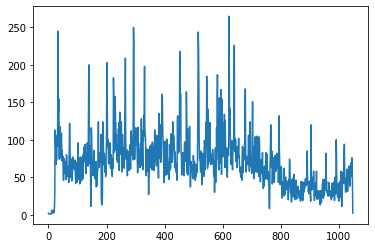

In [230]:
plt.plot(news_metrics['news_count'])

In [301]:
news_metrics.to_csv('df_news_metrics1.csv',index=False)

### ===================================

## *Предсказания*

In [8]:
import statsmodels.api as sm

/home/lena/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# ** Формирование датасетов и выборок **


In [654]:

data = pd.read_csv('df_news_metrics.csv')
data.sort_index(ascending=False,inplace=True)
shift=15
#data['50_day_moving_avg'] = data['close'].rolling(50).mean()
data['15_day_moving_avg'] = data['close'].rolling(15).mean()
data['10_day_volatility'] = data['close'].rolling(10).std(ddof=0)
names= ['news_count','summary_mediana', 'summary_neg_mean','summary_neg_mediana', 'summary_pos_mean']
lag_value=2
for name in names:
    data[name+'_lag'+str(lag_value)]=data[name].shift(lag_value)
create_target(data,shift,0.015)
data['next_growup']=data['grow_up'].shift(-1)
create_target_down(data,shift,0.05)
data['next_growdown']=data['grow_down'].shift(-1)


data.dropna(inplace = True)
#data[['grow_down','grow_down_value']]
#data.head(6)

In [655]:
(data.grow_down_value>0.03).sum()/data.shape[0]

0.6363636363636364

In [656]:
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split

In [657]:
data.columns

Index(['Date', 'news_count', 'title_compound_mean', 'title_compound_mediana',
       'title_pos_mean', 'title_pos_mediana', 'title_neu_mean',
       'title_neu_mediana', 'title_neg_mean', 'title_neg_mediana', 'open',
       'close', 'high', 'low', 'volume', 'summary_compound_mean',
       'summary_compound_mediana', 'summary_pos_mean', 'summary_mediana',
       'summary_neu_mean', 'summary_neu_mediana', 'summary_neg_mean',
       'summary_neg_mediana', '15_day_moving_avg', '10_day_volatility',
       'news_count_lag2', 'summary_mediana_lag2', 'summary_neg_mean_lag2',
       'summary_neg_mediana_lag2', 'summary_pos_mean_lag2', 'grow_up',
       'grow_up_value', 'next_growup', 'grow_down', 'grow_down_value',
       'next_growdown'],
      dtype='object')

### Без новостей

In [658]:
target_name='next_growdown'
df_x = data.reset_index()[[ 'high', 'low','close','open', '10_day_volatility','15_day_moving_avg','volume']]
df_y = data.reset_index()[target_name]
#df_x=MinMaxScaler().fit_transform(df_x)

In [659]:
data.columns

Index(['Date', 'news_count', 'title_compound_mean', 'title_compound_mediana',
       'title_pos_mean', 'title_pos_mediana', 'title_neu_mean',
       'title_neu_mediana', 'title_neg_mean', 'title_neg_mediana', 'open',
       'close', 'high', 'low', 'volume', 'summary_compound_mean',
       'summary_compound_mediana', 'summary_pos_mean', 'summary_mediana',
       'summary_neu_mean', 'summary_neu_mediana', 'summary_neg_mean',
       'summary_neg_mediana', '15_day_moving_avg', '10_day_volatility',
       'news_count_lag2', 'summary_mediana_lag2', 'summary_neg_mean_lag2',
       'summary_neg_mediana_lag2', 'summary_pos_mean_lag2', 'grow_up',
       'grow_up_value', 'next_growup', 'grow_down', 'grow_down_value',
       'next_growdown'],
      dtype='object')

### С новостями

In [660]:
df_x_news = data.reset_index()[['news_count','open', '10_day_volatility','15_day_moving_avg', 
                                'news_count_lag2', 'summary_mediana_lag2', 'summary_neg_mean_lag2',
       'summary_neg_mediana_lag2', 'summary_pos_mean_lag2',
     'summary_mediana', 'summary_neg_mean','summary_neg_mediana', 'summary_pos_mean','close', 'high', 'low','volume']]

#df_x_news=MinMaxScaler().fit_transform(df_x_news)

In [661]:
df_x_news.shape

(1034, 17)

In [662]:
randomstate=np.random.rand()
x_train, x_test, y_train, y_test = train_test_split(df_x, df_y, test_size=0.3,random_state=randomstate,shuffle=False)
x_train_news, x_test_news, y_train, y_test = train_test_split(df_x_news, df_y, test_size=0.3,random_state=randomstate,shuffle=False)


In [663]:
prices_open=np.zeros(x_test.shape[0]+1)
prices_close=np.zeros(x_test.shape[0]+1)
prices_open[0]=x_train.loc[x_test.index[0]-1].open
prices_close[0]=x_train.loc[x_test.index[0]-1].close
prices_open[1:]=x_test.open.values
prices_close[1:]=x_test.close.values

In [664]:
x_train_news=MinMaxScaler().fit_transform(x_train_news)  
x_test_news=MinMaxScaler().fit_transform(x_test_news) 
x_train=MinMaxScaler().fit_transform(x_train)  
x_test=MinMaxScaler().fit_transform(x_test) 

In [665]:
print('Кол-во 1 в тесте:',(y_test>0).sum()/y_test.shape[0])
print('Кол-во 1 в трейне:',(y_train>0).sum()/y_train.shape[0])

Кол-во 1 в тесте: 0.28938906752411575
Кол-во 1 в трейне: 0.45643153526970953


# Делаем ML алгоритмами

# Logistic Regression¶

In [666]:
reg = LogisticRegression()
reg.fit(x_train, y_train)
reg_news = LogisticRegression()
reg_news.fit(x_train_news, y_train)

/home/lena/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/lena/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

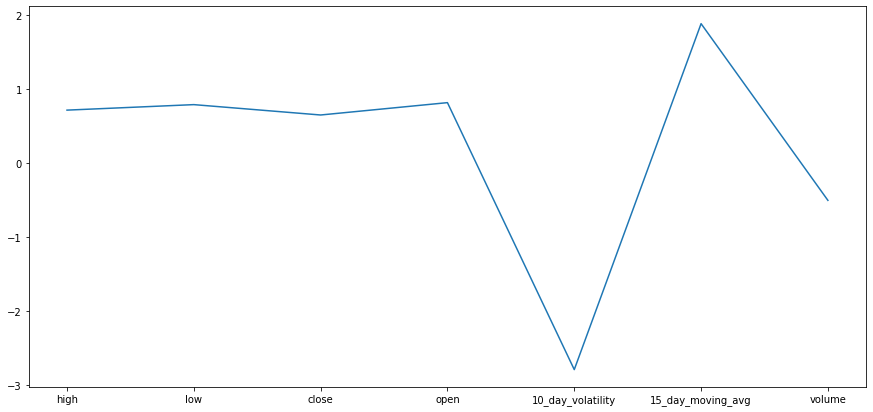

In [667]:
plt.figure(figsize=(15,7))
plt.plot(df_x.columns,reg.coef_[0])

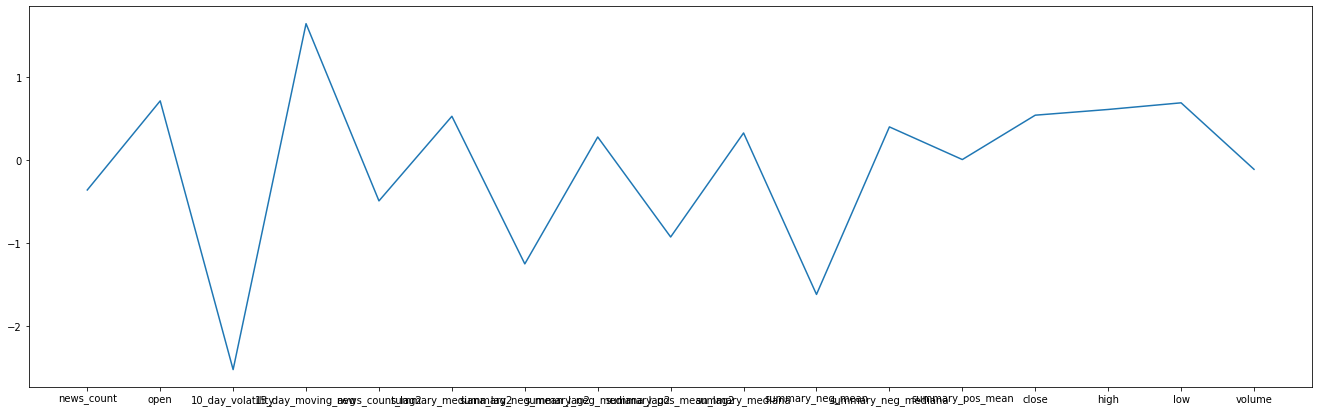

In [668]:
plt.figure(figsize=(23,7))
plt.plot(df_x_news.columns,reg_news.coef_[0])

In [669]:
#y_test.hist()

In [670]:
y_predicted_news_lr = reg_news.predict(x_test_news)
y_predicted_lr = reg.predict(x_test)

In [671]:
print(classification_report(y_test,y_predicted_news_lr))

              precision    recall  f1-score   support

         0.0       0.74      0.37      0.49       221
         1.0       0.30      0.68      0.42        90

    accuracy                           0.46       311
   macro avg       0.52      0.52      0.45       311
weighted avg       0.61      0.46      0.47       311



In [672]:
print(classification_report(y_test,y_predicted_lr))

              precision    recall  f1-score   support

         0.0       0.74      0.35      0.47       221
         1.0       0.30      0.70      0.42        90

    accuracy                           0.45       311
   macro avg       0.52      0.52      0.45       311
weighted avg       0.61      0.45      0.46       311



30 Дней
Без новостей:
 Model profit=  25.394964000000016
 Alternative profit=  -35.342525000000016
 True profit=  1.6074979999999996
С новостями:
 Model profit=  25.394964000000016
 Alternative profit=  -35.342525000000016
 True profit=  0.0


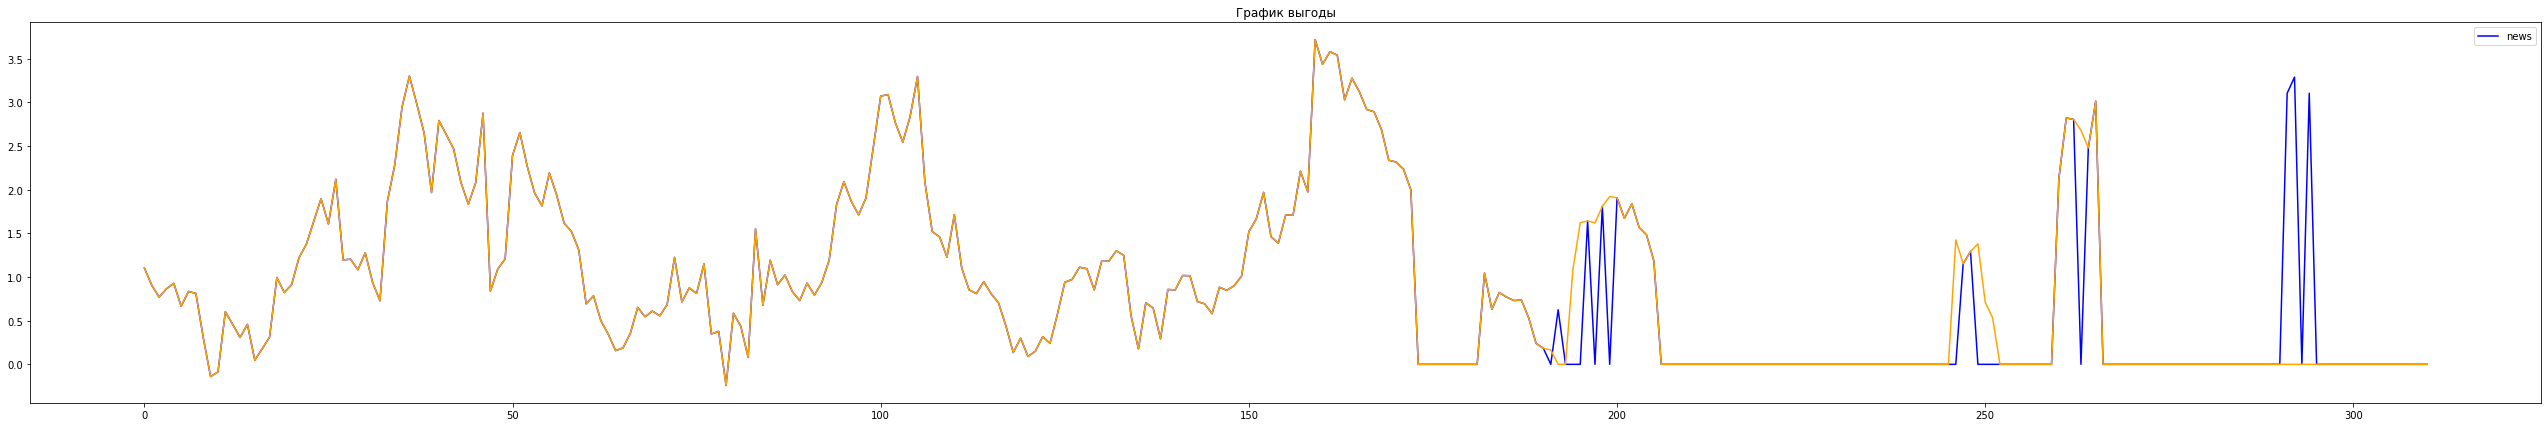

In [673]:
strategy, strategy_news=use_strategy(y_test,y_predicted_lr,y_predicted_news_lr,shift,prices_open,prices_close)
plot_info(strategy_news,strategy)
print_info(30,strategy,strategy_news)

У трушной стратегии в том месте где 0, а у предсказанной рофит больше,значит что цена падала все-таки, но меньше 4%,и продавать все равно было выгодно (  а в трушной стратегии мы ничего не делали)

# Decision Tree Classification

In [674]:
decision_tree=DecisionTreeClassifier()
decision_tree.fit(x_train, y_train)
y_predicted_dt = decision_tree.predict(x_test)
print('Без новостей:')
print(classification_report(y_test,y_predicted_dt))

Без новостей:
              precision    recall  f1-score   support

         0.0       0.66      0.39      0.49       221
         1.0       0.25      0.51      0.34        90

    accuracy                           0.42       311
   macro avg       0.46      0.45      0.41       311
weighted avg       0.54      0.42      0.45       311



In [675]:
decision_tree_news=DecisionTreeClassifier()
decision_tree_news.fit(x_train_news, y_train)
y_predicted_news_dt = decision_tree_news.predict(x_test_news)
print('С новостями:')
print(classification_report(y_test,y_predicted_news_dt))

С новостями:
              precision    recall  f1-score   support

         0.0       0.69      0.32      0.43       221
         1.0       0.28      0.64      0.39        90

    accuracy                           0.41       311
   macro avg       0.48      0.48      0.41       311
weighted avg       0.57      0.41      0.42       311



25 Дней
Без новостей:
 Model profit=  12.129978000000015
 Alternative profit=  -29.735018000000004
 True profit=  0.0
С новостями:
 Model profit=  17.37247300000002
 Alternative profit=  -31.88502000000001
 True profit=  0.0


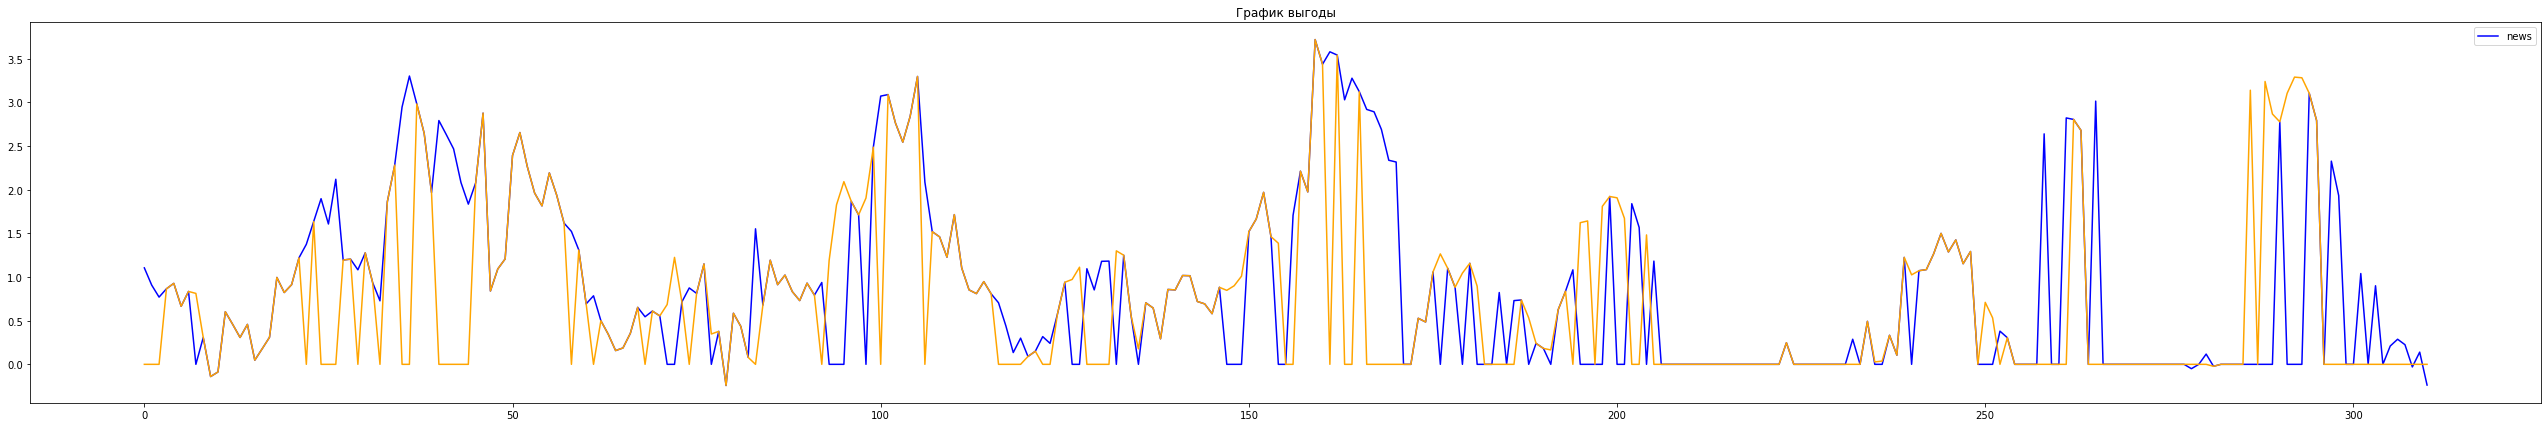

In [676]:
strategy, strategy_news=use_strategy(y_test,y_predicted_dt,y_predicted_news_dt,shift,prices_open,prices_close)
plot_info(strategy_news,strategy)
print_info(25,strategy,strategy_news)

# Random Forest Classification

In [677]:
random_forest=RandomForestClassifier(n_estimators=50,max_depth=10)
random_forest.fit(x_train, y_train)
y_predicted_rf = random_forest.predict(x_test)
print('Без новостей:')
print(classification_report(y_test,y_predicted_rf))

Без новостей:
              precision    recall  f1-score   support

         0.0       0.69      0.27      0.39       221
         1.0       0.28      0.71      0.41        90

    accuracy                           0.40       311
   macro avg       0.49      0.49      0.40       311
weighted avg       0.58      0.40      0.39       311



In [678]:
random_forest_news=RandomForestClassifier(n_estimators=50,max_depth=10)
random_forest_news.fit(x_train_news, y_train)
y_predicted_news_rf = random_forest_news.predict(x_test_news)
print('С новостями:')
print(classification_report(y_test,y_predicted_news_rf))

С новостями:
              precision    recall  f1-score   support

         0.0       0.69      0.43      0.53       221
         1.0       0.27      0.52      0.36        90

    accuracy                           0.45       311
   macro avg       0.48      0.47      0.44       311
weighted avg       0.57      0.45      0.48       311



25 Дней
Без новостей:
 Model profit=  18.18497300000002
 Alternative profit=  -33.81001900000001
 True profit=  0.0
С новостями:
 Model profit=  17.72747700000002
 Alternative profit=  -32.27251600000001
 True profit=  0.0


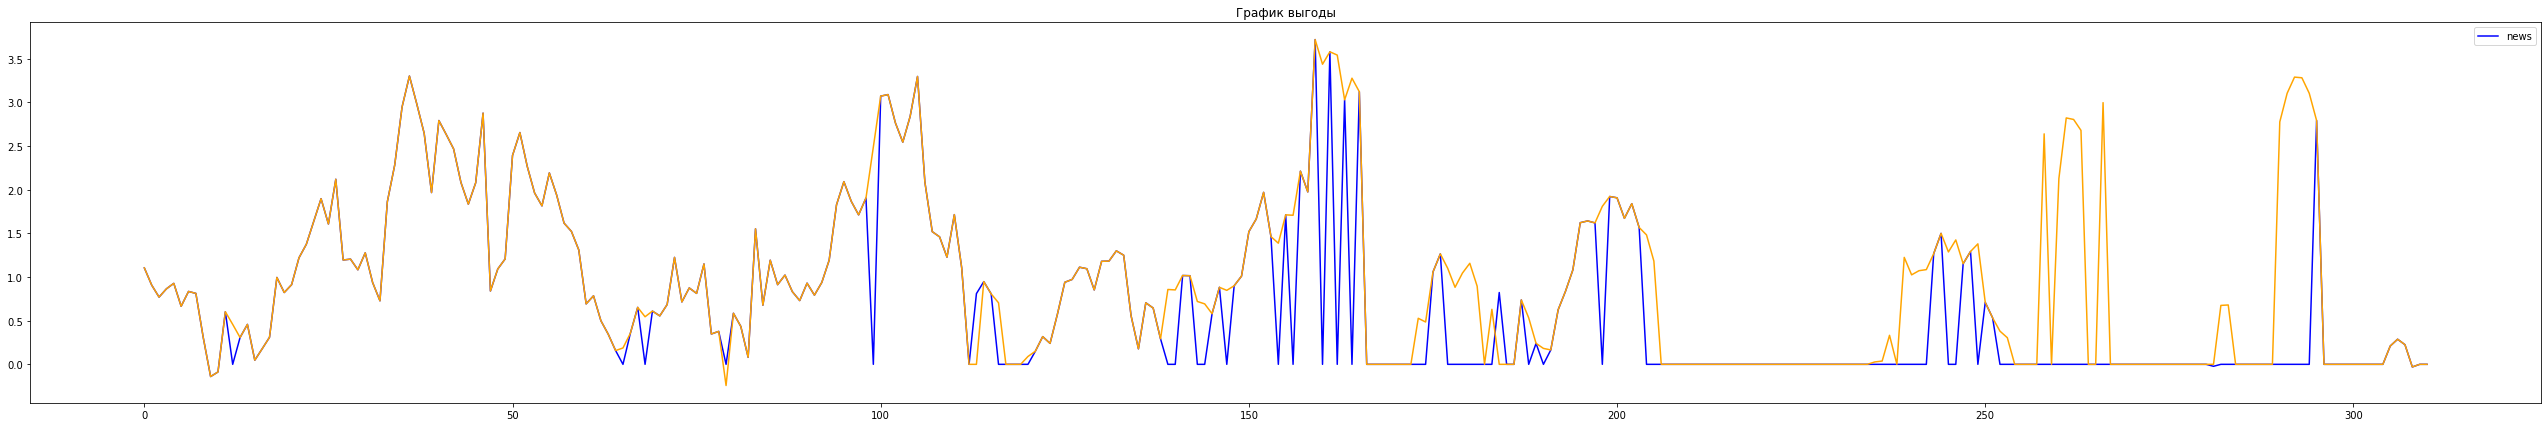

In [680]:
strategy, strategy_news=use_strategy(y_test,y_predicted_rf,y_predicted_news_rf,shift,prices_open,prices_close)
plot_info(strategy_news,strategy)
print_info(25,strategy,strategy_news)

# GradientBoostingClassifier

In [681]:
boosting=GradientBoostingClassifier()
boosting.fit(x_train, y_train)
y_predicted_gb = boosting.predict(x_test)
print('Без новостей:')
print(classification_report(y_test,y_predicted_gb))

Без новостей:
              precision    recall  f1-score   support

         0.0       0.71      0.29      0.41       221
         1.0       0.29      0.71      0.41        90

    accuracy                           0.41       311
   macro avg       0.50      0.50      0.41       311
weighted avg       0.59      0.41      0.41       311



In [682]:
boosting_news=GradientBoostingClassifier()
boosting_news.fit(x_train_news, y_train)
y_predicted_news_gb = boosting_news.predict(x_test_news)
print('С новостями:')
print(classification_report(y_test,y_predicted_news_gb))

С новостями:
              precision    recall  f1-score   support

         0.0       0.78      0.31      0.44       221
         1.0       0.32      0.79      0.45        90

    accuracy                           0.45       311
   macro avg       0.55      0.55      0.45       311
weighted avg       0.65      0.45      0.44       311



25 Дней
Без новостей:
 Model profit=  18.18497300000002
 Alternative profit=  -33.81001900000001
 True profit=  0.0
С новостями:
 Model profit=  14.272483000000015
 Alternative profit=  -22.865010000000012
 True profit=  0.0


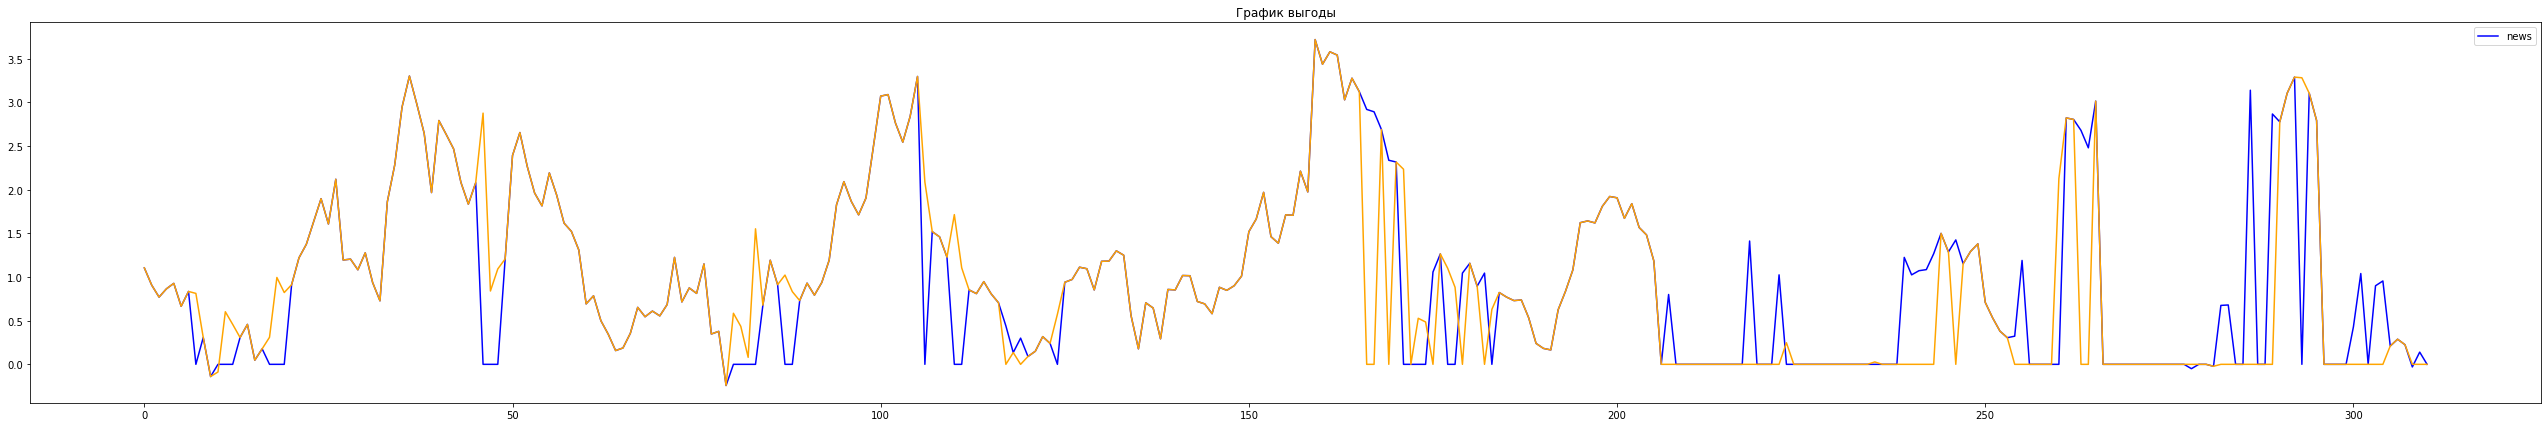

In [683]:
strategy, strategy_news=use_strategy(y_test,y_predicted_gb,y_predicted_news_gb,shift,prices_open,prices_close)
plot_info(strategy_news,strategy)
print_info(25,strategy,strategy_news)

# Всякие картинки

In [346]:
result=pd.DataFrame()
result['predict_lr']=y_predicted_lr
result['predict_news_lr']=y_predicted_news_lr
result['predict_dt']=y_predicted_dt
result['predict_news_dt']=y_predicted_news_dt
result['predict_rf']=y_predicted_rf
result['predict_news_rf']=y_predicted_news_rf
result['predict_gb']=y_predicted_gb
result['predict_news_gb']=y_predicted_news_gb
result['true']=y_test.values
result['value']=data['grow_down_value'].shift(-1)
result.dropna(inplace=True)

In [347]:
result

,predict_lr,predict_news_lr,predict_dt,predict_news_dt,predict_rf,predict_news_rf,predict_gb,predict_news_gb,true,value
2,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.007804
3,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.011311
4,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,-0.001230
5,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.009375
6,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,0.011948
...,...,...,...,...,...,...,...,...,...,...
306,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.021704
307,0.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.017362
308,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.024050
309,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.022466


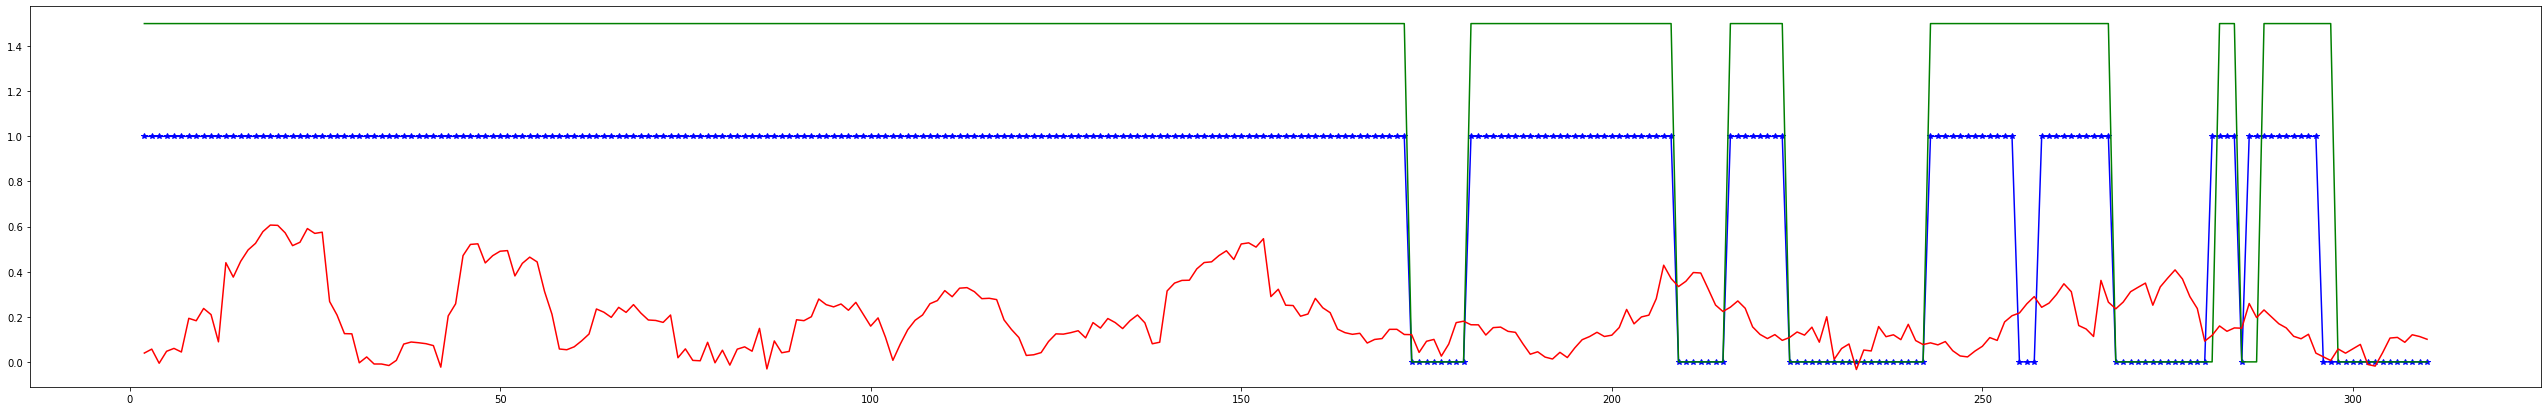

In [348]:
plt.figure(figsize=(45,7))
plt.plot(result.predict_lr,c='blue',marker='*')
plt.plot(1.5*result.predict_news_lr,c='green')
#plt.plot(1.25*result.true,c='orange')
plt.plot(5*result.value,c='red')

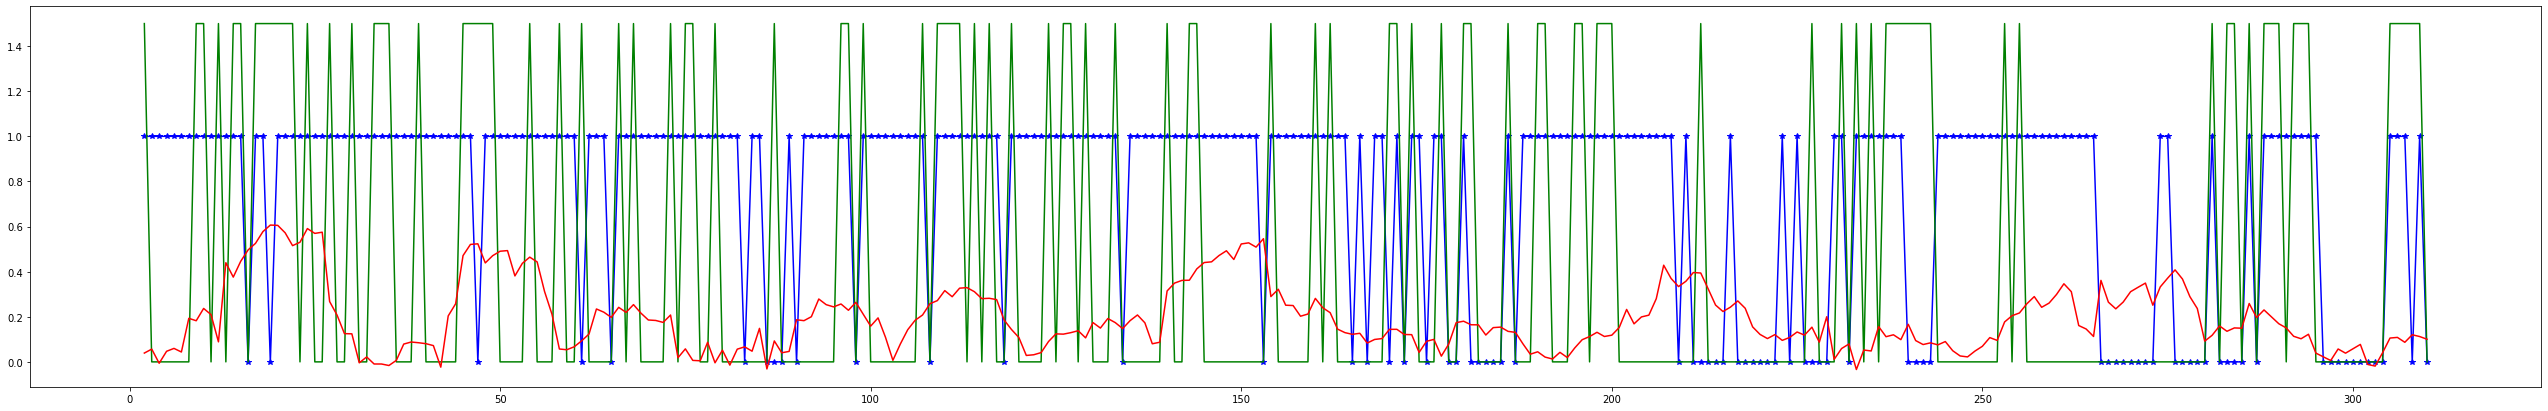

In [349]:
plt.figure(figsize=(45,7))
plt.plot(result.predict_dt,c='blue',marker='*')
plt.plot(1.5*result.predict_news_dt,c='green')
#plt.plot(1.25*result.true,c='orange')
plt.plot(5*result.value,c='red')

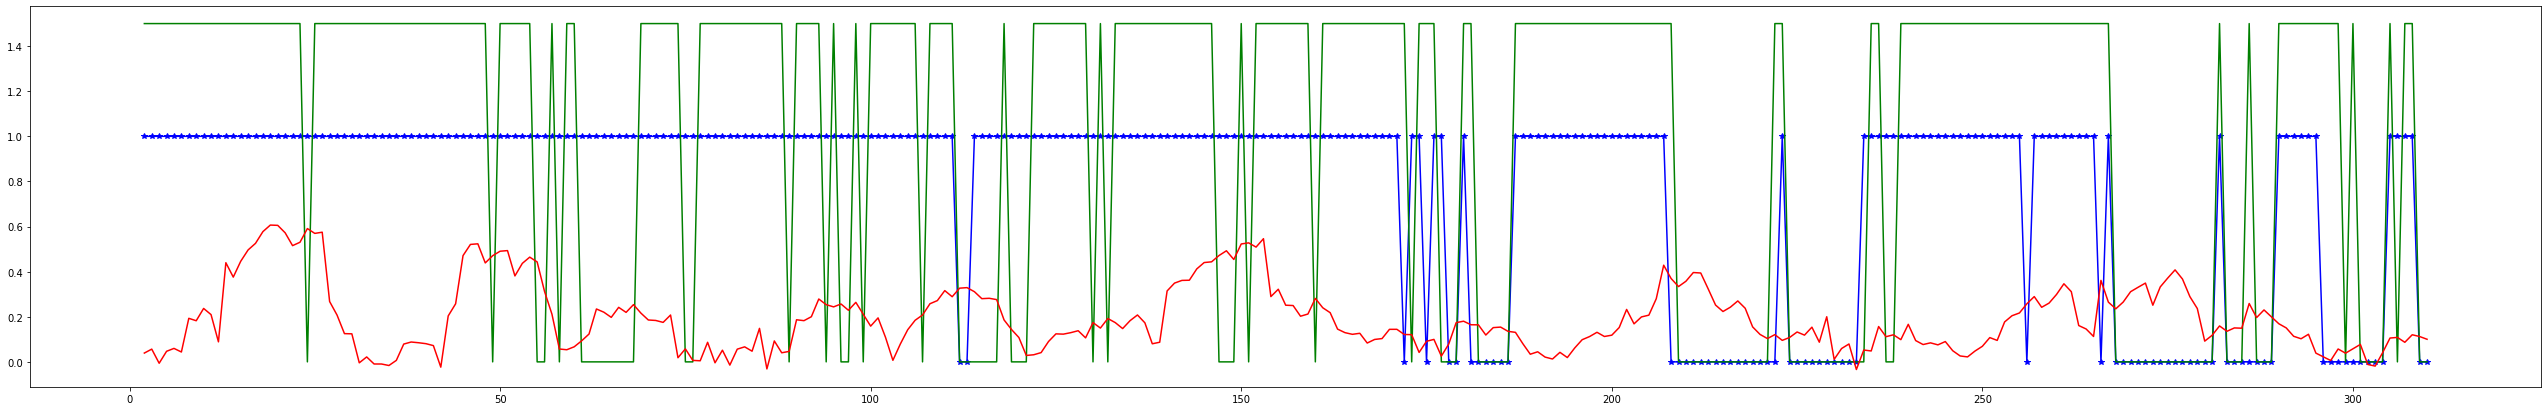

In [350]:
plt.figure(figsize=(45,7))
plt.plot(result.predict_rf,c='blue',marker='*')
plt.plot(1.5*result.predict_news_rf,c='green')
#plt.plot(1.25*result.true,c='orange')
plt.plot(5*result.value,c='red')

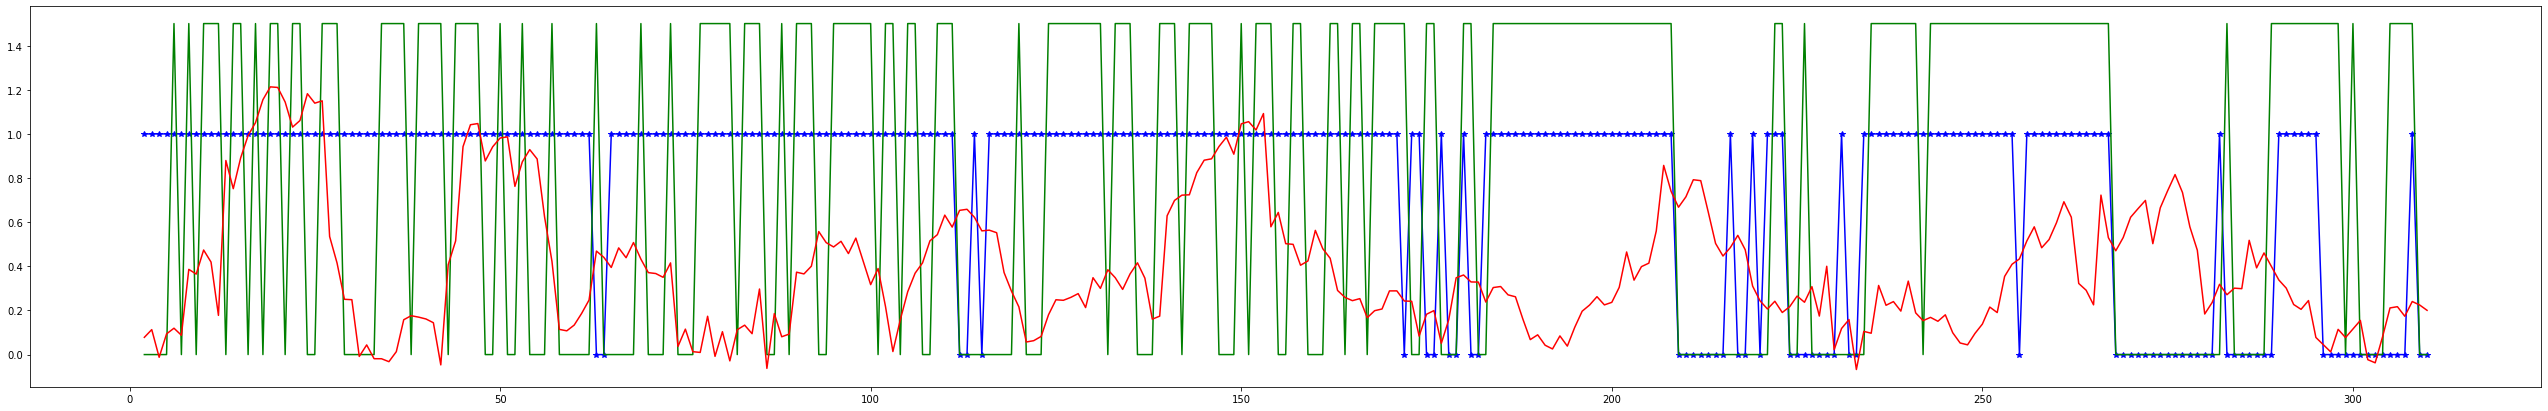

In [351]:
plt.figure(figsize=(45,7))
plt.plot(result.predict_gb,c='blue',marker='*')
plt.plot(1.5*result.predict_news_gb,c='green')
#plt.plot(1.25*result.true,c='orange')
plt.plot(10*result.value,c='red')

# Linear Regression

In [56]:
reg = LinearRegression()
x_train, x_test, y_train, y_test = train_test_split(df_x, df_y, test_size=0.3,random_state=4,shuffle=False)
reg.fit(x_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [336]:
reg_news = LinearRegression()
x_train_news, x_test_news, y_train, y_test = train_test_split(df_x_news, df_y, test_size=0.3,random_state=4,shuffle=False)
reg_news.fit(x_train_news, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [337]:
y_predicted_news = reg_news.predict(x_test_news)
y_predicted = reg.predict(x_test)

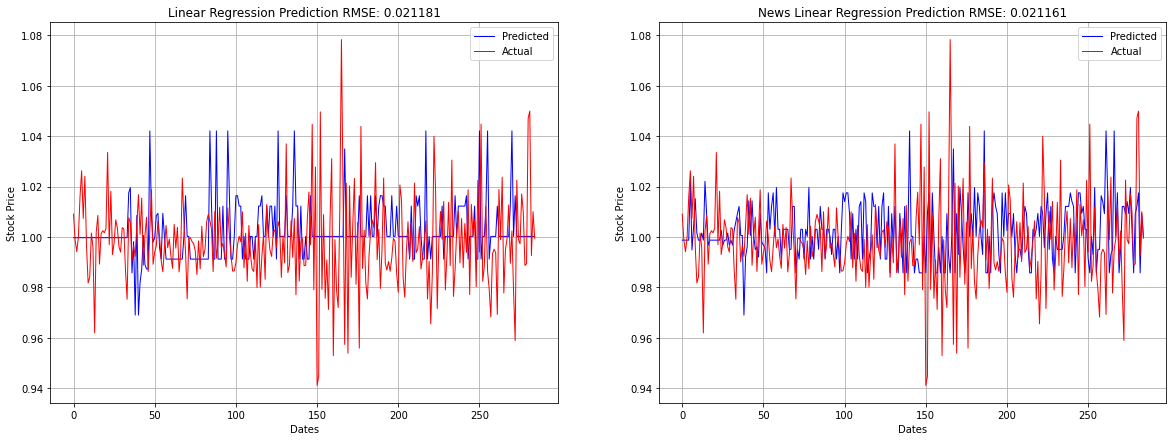

In [242]:
## plt.figure(figsize=(15,7))
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20, 7))
ax[0].plot(y_predicted, color='blue', linewidth=1, label='Predicted')
ax[0].plot(y_test.values, color='red', linewidth=1, label='Actual')
#ax[0].plot(x_test_news[:,0], color='green', linewidth=1, label='News count')
#ax[0].plot( 2*(-2*x_test['50_day_moving_avg'].values*x_test['10_day_volatility'].values-0.255)/125+224,color='green', linewidth=1, label='50day_ma')
#ax[0].plot( x_test['10_day_volatility'].values,color='orange', linewidth=1, label='10day_vol')#'10_day_volatility'
ax[0].set_title('Linear Regression Prediction RMSE: %.6f'% np.sqrt(sum((y_predicted-y_test.values)**2)/len(y_test.values)))
ax[0].set_ylabel('Stock Price')
ax[0].set_xlabel('Dates')
ax[0].legend()
ax[0].grid(True)

ax[1].plot(y_predicted_news, color='blue', linewidth=1, label='Predicted')
ax[1].plot(y_test.values, color='red', linewidth=1, label='Actual')
#ax[1].plot( 2*(-2*x_test['50_day_moving_avg'].values*x_test['10_day_volatility'].values-0.255)/125+224,color='green', linewidth=1, label='50day_ma')
#ax[1].plot( x_test['10_day_volatility'].values,color='orange', linewidth=1, label='10day_vol')#'10_day_volatility'
ax[1].set_title('News Linear Regression Prediction RMSE: %.6f'% np.sqrt(sum((y_predicted_news-y_test.values)**2)/len(y_test.values)))
ax[1].set_ylabel('Stock Price')
ax[1].set_xlabel('Dates')
ax[1].legend()
ax[1].grid(True)
plt.show()

In [203]:
errors = abs (y_predicted - y_test.values)
print('Mean Absolute Error: ', round(np.mean(errors), 2), 'degrees.')
errors_news = abs (y_predicted_news - y_test.values)
print('News Mean Absolute Error: ', round(np.mean(errors_news), 2), 'degrees.')

Mean Absolute Error:  0.01 degrees.
News Mean Absolute Error:  0.01 degrees.


In [204]:
# MAPE
mape = 100 * (errors/y_test.values)
accuracy = 100 - np.mean(mape)
print('Accuracy: ', round(accuracy, 2), '%.')

Accuracy:  98.65 %.


# SVR

In [205]:
clf = SVR(kernel='rbf', C=1e3, gamma=0.1)
clf.fit(x_train, y_train) 
predictions = clf.predict(x_test)

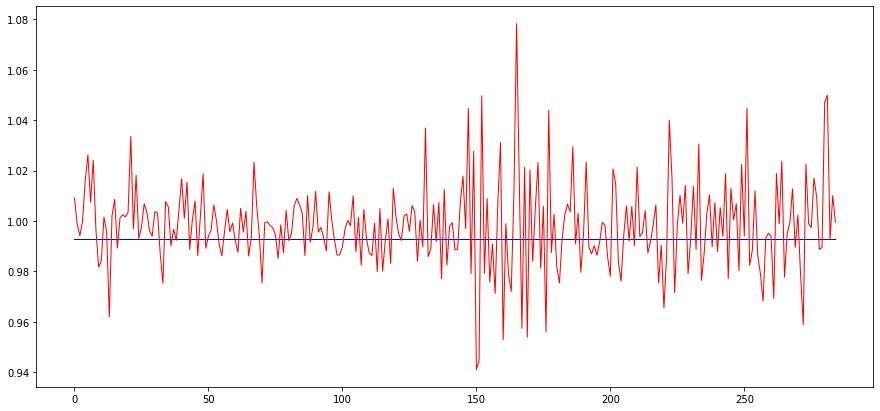

In [206]:
plt.figure(figsize=(15,7))
plt.plot(predictions, color='blue', linewidth=1, label='Predicted')
plt.plot(y_test.values, color='red', linewidth=1, label='Actual')

In [109]:
errors = abs(predictions - y_test.values)
mape = 100 * (errors/y_test.values)
accuracy = 100 - np.mean(mape)
print('Accuracy: ', round(accuracy, 2), '%.')

Accuracy:  75.93 %.


# Decision Tree Regression

In [207]:
regressor = DecisionTreeRegressor(max_depth=10)
regressor.fit(x_train, y_train)
predictions = regressor.predict(x_test)

In [210]:
regressor_news = DecisionTreeRegressor(max_depth=10)
regressor_news.fit(x_train_news, y_train)
predictions_news = regressor_news.predict(x_test_news)

In [211]:
y_predicted_news = regressor_news.predict(x_test_news)
y_predicted = regressor.predict(x_test)

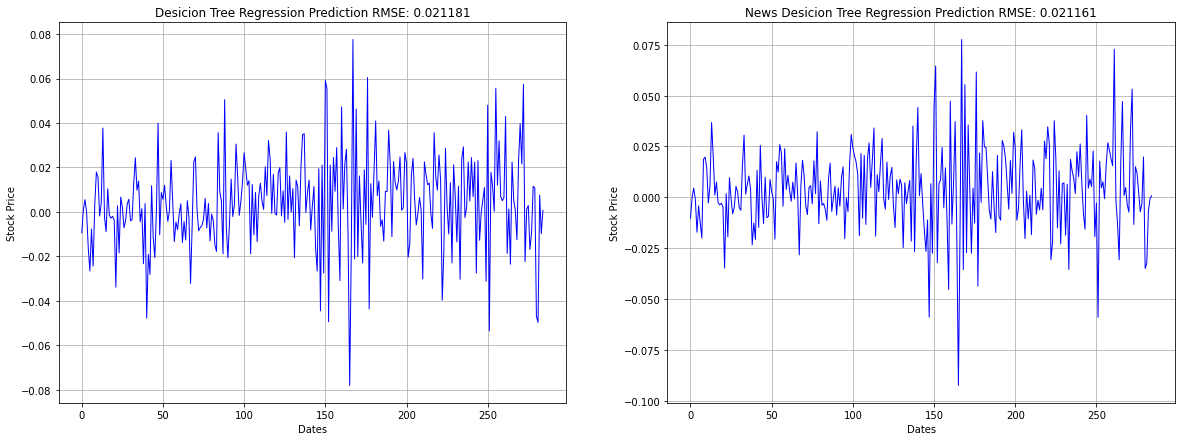

In [307]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20, 7))
ax[0].plot(y_predicted-y_test.values, color='blue', linewidth=1, label='Predicted')
#ax[0].plot(y_test.values, color='red', linewidth=1, label='Actual')
#ax[0].plot( 2*(-2*x_test['50_day_moving_avg'].values*x_test['10_day_volatility'].values-0.255)/125+224,color='green', linewidth=1, label='50day_ma')
#ax[0].plot( x_test['10_day_volatility'].values,color='orange', linewidth=1, label='10day_vol')#'10_day_volatility'
ax[0].set_title('Desicion Tree Regression Prediction RMSE: %.6f'% np.sqrt(sum((y_predicted-y_test.values)**2)/len(y_test.values)))
ax[0].set_ylabel('Stock Price')
ax[0].set_xlabel('Dates')
ax[0].grid(True)

ax[1].plot(y_predicted_news-y_test.values, color='blue', linewidth=1, label='Predicted')
#ax[1].plot(y_test.values, color='red', linewidth=1, label='Actual')
#ax[1].plot( 2*(-2*x_test['50_day_moving_avg'].values*x_test['10_day_volatility'].values-0.255)/125+224,color='green', linewidth=1, label='50day_ma')
#ax[1].plot( x_test['10_day_volatility'].values,color='orange', linewidth=1, label='10day_vol')#'10_day_volatility'
ax[1].set_title('News Desicion Tree Regression Prediction RMSE: %.6f'% np.sqrt(sum((y_predicted_news-y_test.values)**2)/len(y_test.values)))
ax[1].set_ylabel('Stock Price')
ax[1].set_xlabel('Dates')
ax[1].grid(True)
plt.show()

In [112]:
errors = abs(predictions - y_test.values)
mape = 100 * (errors/y_test.values)
accuracy = 100 - np.mean(mape)
print('Accuracy: ', round(accuracy, 2), '%.')

Accuracy:  95.86 %.


# Regression Forest

In [113]:
regressor = RandomForestRegressor(n_estimators=100, max_depth=8, random_state=0)
regressor.fit(x_train, y_train)
predictions = regressor.predict(x_test)
regressor_news = RandomForestRegressor(n_estimators=100, max_depth=8, random_state=0)
regressor_news.fit(x_train_news, y_train)
predictions_news = regressor_news.predict(x_test_news)

In [213]:
y_predicted_news = regressor_news.predict(x_test_news)
y_predicted = regressor.predict(x_test)

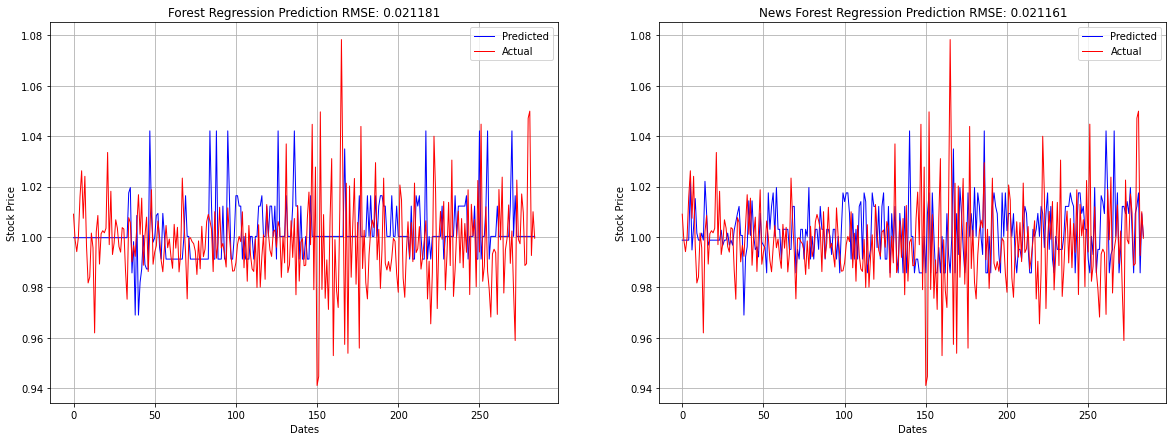

In [218]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20, 7))
ax[0].plot(y_predicted, color='blue', linewidth=1, label='Predicted')
ax[0].plot(y_test.values, color='red', linewidth=1, label='Actual')
#ax[0].plot( 2*(-2*x_test['50_day_moving_avg'].values*x_test['10_day_volatility'].values-0.255)/125+224,color='green', linewidth=1, label='50day_ma')
#ax[0].plot( x_test['10_day_volatility'].values,color='orange', linewidth=1, label='10day_vol')#'10_day_volatility'
ax[0].set_title('Forest Regression Prediction RMSE: %.6f'% np.sqrt(sum((y_predicted-y_test.values)**2)/len(y_test.values)))
ax[0].set_ylabel('Stock Price')
ax[0].set_xlabel('Dates')
ax[0].legend()
ax[0].grid(True)

ax[1].plot(y_predicted_news, color='blue', linewidth=1, label='Predicted')
ax[1].plot(y_test.values, color='red', linewidth=1, label='Actual')
#ax[1].plot( 2*(-2*x_test['50_day_moving_avg'].values*x_test['10_day_volatility'].values-0.255)/125+224,color='green', linewidth=1, label='50day_ma')
#ax[1].plot( x_test['10_day_volatility'].values,color='orange', linewidth=1, label='10day_vol')#'10_day_volatility'
ax[1].set_title('News Forest Regression Prediction RMSE: %.6f'% np.sqrt(sum((y_predicted_news-y_test.values)**2)/len(y_test.values)))
ax[1].set_ylabel('Stock Price')
ax[1].set_xlabel('Dates')
ax[1].legend()
ax[1].grid(True)
plt.show()

In [115]:
errors = abs(predictions - y_test.values)
mape = 100 * (errors/y_test.values)
accuracy = 100 - np.mean(mape)
print('Accuracy: ', round(accuracy, 2), '%.')

Accuracy:  95.74 %.
